## Conditional GAN


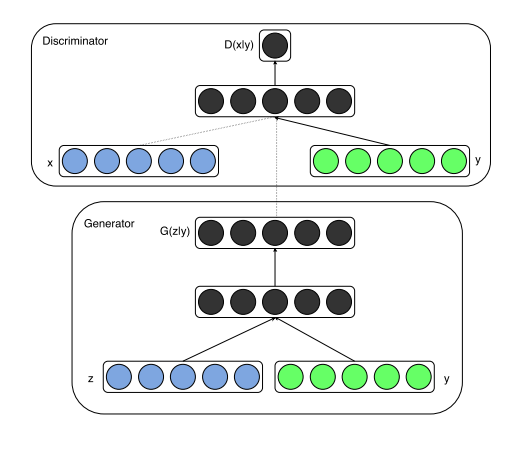


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import imageio
import torchvision.utils as vutils
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

In [2]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

# download path 정의
download_root = './MNIST_DATASET'

In [3]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
#     transforms.Normalize((0.5,), (1.0,))
])

In [4]:
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
train_dataset.data.shape, test_dataset.data.shape, train_dataset.targets.shape, test_dataset.targets.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [5]:
all_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
train_loader = torch.utils.data.DataLoader(dataset=all_dataset, 
                         batch_size=batch_size,
                         shuffle=True, drop_last=True)
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [6]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args[0]

    def forward(self, x):
        return x.view(self.shape)

In [7]:
class Generator(nn.Module) :
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(generator_in_channels, 7 * 7 * generator_in_channels),
            nn.LeakyReLU(0.2),
            Reshape((-1, generator_in_channels,7,7)),
            nn.ConvTranspose2d(generator_in_channels, 128, (4,4), (2,2)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 128, (4,4), (2,2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, (7,7)),
            nn.Sigmoid())
    def forward(self, noise, one_hot_labels):
        random_vector_labels = torch.cat(
            (noise, one_hot_labels), 1
        )
        generated_images = self.generator(random_vector_labels)
        return generated_images

In [8]:
class Discriminator(nn.Module) :
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(discriminator_in_channels, 128, (3,3), (2,2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, (3,3), (2,2)),
            nn.LeakyReLU(0.2),
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(),
            nn.Linear(128,1))
    def forward(self, images, one_hot_labels):
        image_size = images.shape[2]
        
        image_one_hot_labels = one_hot_labels[:,:,None,None]
        image_one_hot_labels = image_one_hot_labels.repeat_interleave(
            torch.tensor(image_size*image_size).to(device)
        )
        image_one_hot_labels = image_one_hot_labels.view(
            (-1, image_size, image_size, num_classes)
        )
        image_one_hot_labels = image_one_hot_labels.permute(0,3,1,2)
        images_and_labels = torch.cat((images, image_one_hot_labels), 1)
        predictions = self.discriminator(images_and_labels)
        return predictions, images_and_labels

In [9]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator()
discriminator = Discriminator()
generator = generator.to(device)
discriminator = discriminator.to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0003)
criterion = torch.nn.BCEWithLogitsLoss().to(device)

epochs = 20

In [11]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear) :
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

In [12]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(11, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): AdaptiveMaxPool2d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Epoch: [0][0/1093]	generator_loss: 0.7221 (0.7221)	discriminator_loss: 0.7054 (0.7054)	
Epoch: [0][200/1093]	generator_loss: 1.9128 (2.8427)	discriminator_loss: 0.3416 (0.2614)	
Epoch: [0][400/1093]	generator_loss: 1.1156 (2.1347)	discriminator_loss: 0.5326 (0.3677)	
Epoch: [0][600/1093]	generator_loss: 2.3530 (1.9789)	discriminator_loss: 0.2476 (0.3674)	
Epoch: [0][800/1093]	generator_loss: 1.8978 (1.9457)	discriminator_loss: 0.2030 (0.3655)	
Epoch: [0][1000/1093]	generator_loss: 2.1912 (1.9326)	discriminator_loss: 0.1383 (0.3664)	


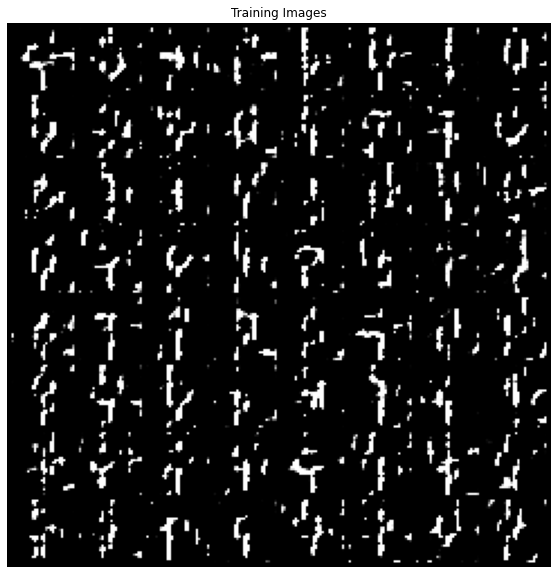

Epoch: [1][0/1093]	generator_loss: 1.9589 (1.9589)	discriminator_loss: 0.3317 (0.3317)	
Epoch: [1][200/1093]	generator_loss: 1.9738 (1.9301)	discriminator_loss: 0.3309 (0.3413)	
Epoch: [1][400/1093]	generator_loss: 2.6104 (1.9323)	discriminator_loss: 0.1651 (0.3617)	
Epoch: [1][600/1093]	generator_loss: 2.2198 (1.9075)	discriminator_loss: 0.3321 (0.3673)	
Epoch: [1][800/1093]	generator_loss: 1.8496 (1.8647)	discriminator_loss: 0.3629 (0.3803)	
Epoch: [1][1000/1093]	generator_loss: 1.6215 (1.8686)	discriminator_loss: 0.3951 (0.3804)	


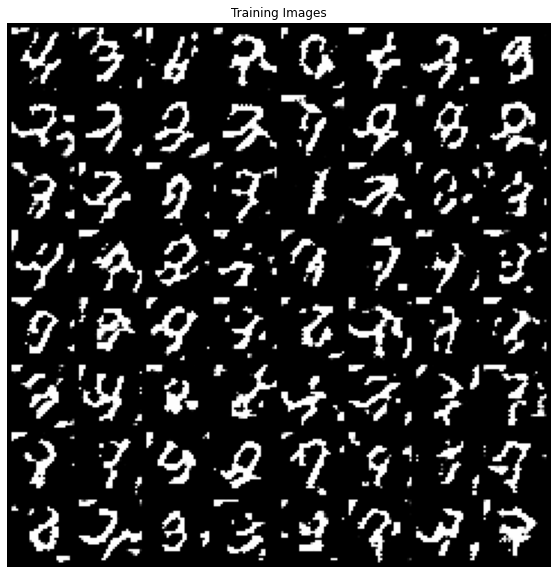

Epoch: [2][0/1093]	generator_loss: 1.8077 (1.8077)	discriminator_loss: 0.3429 (0.3429)	
Epoch: [2][200/1093]	generator_loss: 1.4911 (1.8722)	discriminator_loss: 0.3964 (0.3514)	
Epoch: [2][400/1093]	generator_loss: 2.4287 (1.9029)	discriminator_loss: 0.2160 (0.3290)	
Epoch: [2][600/1093]	generator_loss: 2.1570 (1.9751)	discriminator_loss: 0.2674 (0.3113)	
Epoch: [2][800/1093]	generator_loss: 2.4095 (2.0514)	discriminator_loss: 0.2328 (0.2946)	
Epoch: [2][1000/1093]	generator_loss: 2.7048 (2.1252)	discriminator_loss: 0.2140 (0.2741)	


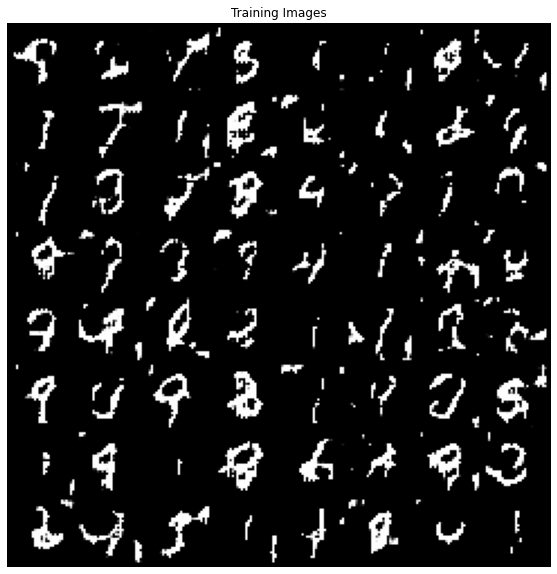

Epoch: [3][0/1093]	generator_loss: 2.6634 (2.6634)	discriminator_loss: 0.1467 (0.1467)	
Epoch: [3][200/1093]	generator_loss: 2.3199 (2.7164)	discriminator_loss: 0.1874 (0.1645)	
Epoch: [3][400/1093]	generator_loss: 2.5257 (2.8596)	discriminator_loss: 0.1265 (0.1597)	
Epoch: [3][600/1093]	generator_loss: 2.5374 (2.7649)	discriminator_loss: 0.4080 (0.1696)	
Epoch: [3][800/1093]	generator_loss: 1.2880 (2.4499)	discriminator_loss: 0.5342 (0.2726)	
Epoch: [3][1000/1093]	generator_loss: 1.2054 (2.2080)	discriminator_loss: 0.5544 (0.3342)	


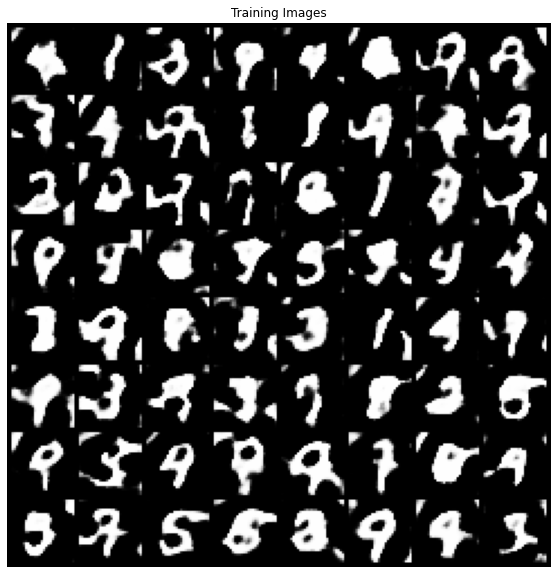

Epoch: [4][0/1093]	generator_loss: 2.0066 (2.0066)	discriminator_loss: 0.4590 (0.4590)	
Epoch: [4][200/1093]	generator_loss: 1.2214 (1.4887)	discriminator_loss: 0.5902 (0.5371)	
Epoch: [4][400/1093]	generator_loss: 1.1705 (1.3280)	discriminator_loss: 0.6303 (0.5605)	
Epoch: [4][600/1093]	generator_loss: 1.0476 (1.2909)	discriminator_loss: 0.6070 (0.5712)	
Epoch: [4][800/1093]	generator_loss: 1.2166 (1.2435)	discriminator_loss: 0.6204 (0.5792)	
Epoch: [4][1000/1093]	generator_loss: 0.9009 (1.2125)	discriminator_loss: 0.7656 (0.5831)	


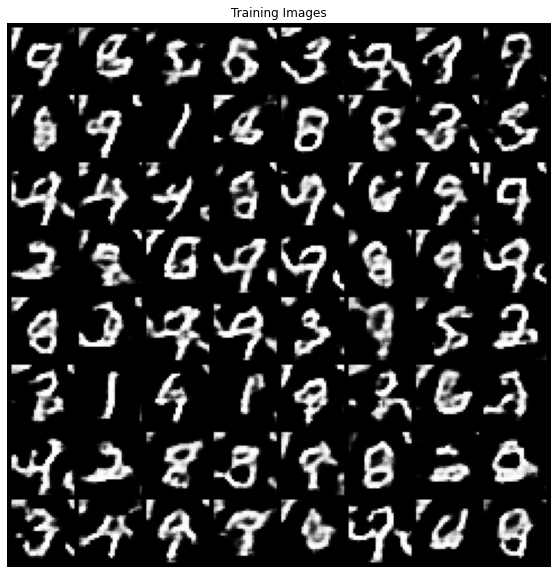

Epoch: [5][0/1093]	generator_loss: 1.2568 (1.2568)	discriminator_loss: 0.4805 (0.4805)	
Epoch: [5][200/1093]	generator_loss: 0.9595 (1.1148)	discriminator_loss: 0.6843 (0.6238)	
Epoch: [5][400/1093]	generator_loss: 0.8383 (1.0814)	discriminator_loss: 0.6131 (0.6255)	
Epoch: [5][600/1093]	generator_loss: 1.0320 (1.0400)	discriminator_loss: 0.5756 (0.6249)	
Epoch: [5][800/1093]	generator_loss: 0.8955 (1.0327)	discriminator_loss: 0.6437 (0.6234)	
Epoch: [5][1000/1093]	generator_loss: 1.0624 (1.0243)	discriminator_loss: 0.5811 (0.6240)	


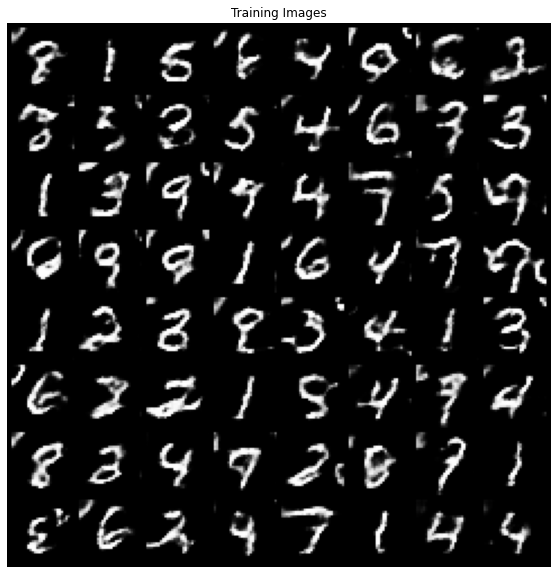

Epoch: [6][0/1093]	generator_loss: 0.6710 (0.6710)	discriminator_loss: 0.7874 (0.7874)	
Epoch: [6][200/1093]	generator_loss: 0.9698 (0.9505)	discriminator_loss: 0.6632 (0.6369)	
Epoch: [6][400/1093]	generator_loss: 0.9620 (0.9352)	discriminator_loss: 0.5897 (0.6321)	
Epoch: [6][600/1093]	generator_loss: 1.0108 (0.9448)	discriminator_loss: 0.6790 (0.6331)	
Epoch: [6][800/1093]	generator_loss: 0.9035 (0.9354)	discriminator_loss: 0.5755 (0.6337)	
Epoch: [6][1000/1093]	generator_loss: 0.9036 (0.9283)	discriminator_loss: 0.6201 (0.6346)	


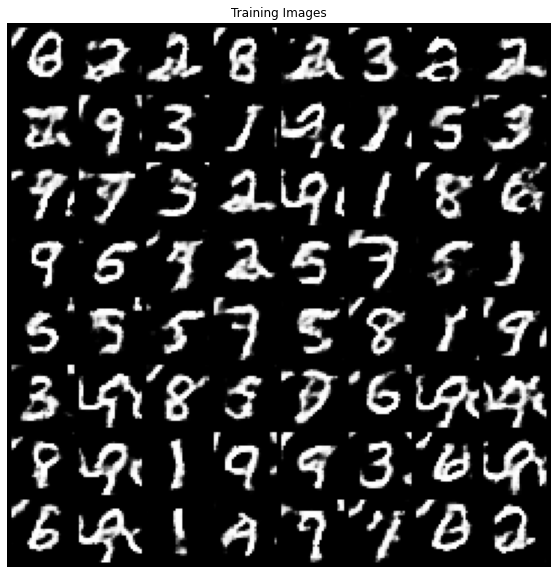

Epoch: [7][0/1093]	generator_loss: 1.0058 (1.0058)	discriminator_loss: 0.6491 (0.6491)	
Epoch: [7][200/1093]	generator_loss: 0.9443 (0.8786)	discriminator_loss: 0.6629 (0.6388)	
Epoch: [7][400/1093]	generator_loss: 0.8279 (0.8898)	discriminator_loss: 0.6329 (0.6390)	
Epoch: [7][600/1093]	generator_loss: 0.9548 (0.8828)	discriminator_loss: 0.5828 (0.6384)	
Epoch: [7][800/1093]	generator_loss: 0.8003 (0.8806)	discriminator_loss: 0.6402 (0.6415)	
Epoch: [7][1000/1093]	generator_loss: 0.8106 (0.8778)	discriminator_loss: 0.6561 (0.6417)	


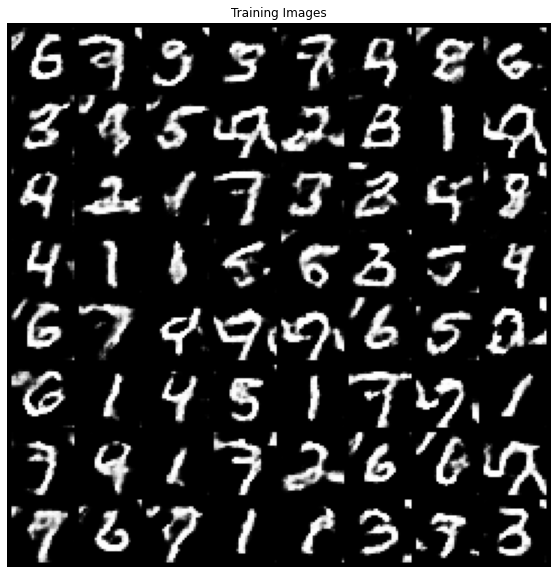

Epoch: [8][0/1093]	generator_loss: 0.9364 (0.9364)	discriminator_loss: 0.6599 (0.6599)	
Epoch: [8][200/1093]	generator_loss: 0.8167 (0.8616)	discriminator_loss: 0.6464 (0.6493)	
Epoch: [8][400/1093]	generator_loss: 0.7576 (0.8523)	discriminator_loss: 0.6331 (0.6479)	
Epoch: [8][600/1093]	generator_loss: 0.7917 (0.8457)	discriminator_loss: 0.6499 (0.6482)	
Epoch: [8][800/1093]	generator_loss: 1.0572 (0.8442)	discriminator_loss: 0.6168 (0.6482)	
Epoch: [8][1000/1093]	generator_loss: 0.8089 (0.8415)	discriminator_loss: 0.6190 (0.6483)	


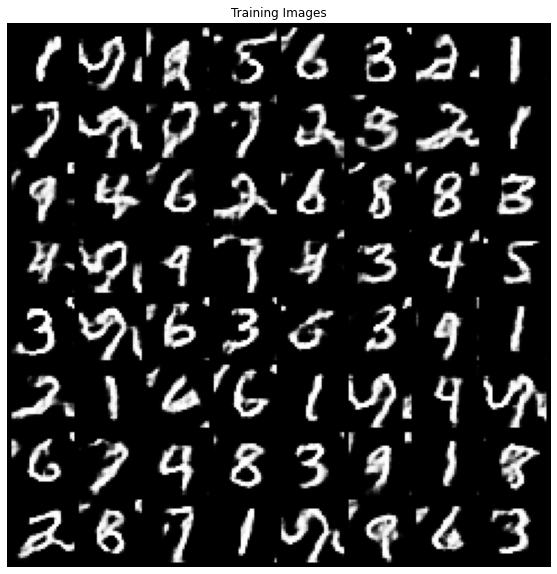

Epoch: [9][0/1093]	generator_loss: 0.8748 (0.8748)	discriminator_loss: 0.6552 (0.6552)	
Epoch: [9][200/1093]	generator_loss: 0.7316 (0.8369)	discriminator_loss: 0.6512 (0.6433)	
Epoch: [9][400/1093]	generator_loss: 0.9418 (0.8549)	discriminator_loss: 0.5706 (0.6425)	
Epoch: [9][600/1093]	generator_loss: 0.7947 (0.8452)	discriminator_loss: 0.6497 (0.6462)	
Epoch: [9][800/1093]	generator_loss: 0.8018 (0.8500)	discriminator_loss: 0.6713 (0.6442)	
Epoch: [9][1000/1093]	generator_loss: 0.6700 (0.8546)	discriminator_loss: 0.7095 (0.6454)	


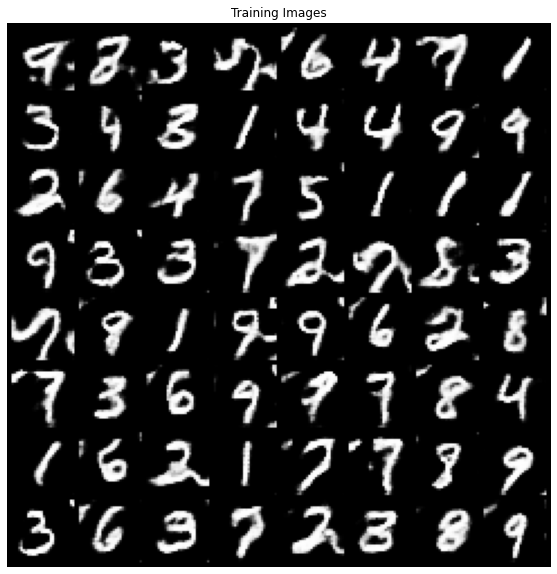

Epoch: [10][0/1093]	generator_loss: 1.0065 (1.0065)	discriminator_loss: 0.5898 (0.5898)	
Epoch: [10][200/1093]	generator_loss: 0.7974 (0.8293)	discriminator_loss: 0.6769 (0.6532)	
Epoch: [10][400/1093]	generator_loss: 0.8321 (0.8314)	discriminator_loss: 0.6687 (0.6497)	
Epoch: [10][600/1093]	generator_loss: 0.8728 (0.8286)	discriminator_loss: 0.5631 (0.6499)	
Epoch: [10][800/1093]	generator_loss: 0.7841 (0.8343)	discriminator_loss: 0.6314 (0.6495)	
Epoch: [10][1000/1093]	generator_loss: 0.8267 (0.8311)	discriminator_loss: 0.7194 (0.6487)	


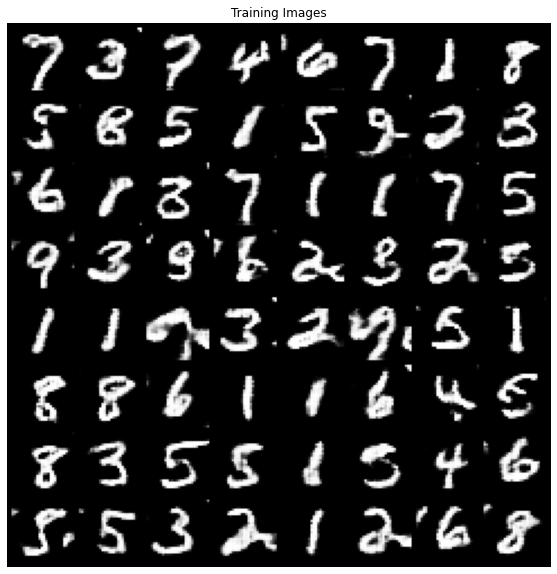

Epoch: [11][0/1093]	generator_loss: 0.7921 (0.7921)	discriminator_loss: 0.5698 (0.5698)	
Epoch: [11][200/1093]	generator_loss: 0.8851 (0.8319)	discriminator_loss: 0.6743 (0.6530)	
Epoch: [11][400/1093]	generator_loss: 0.8544 (0.8417)	discriminator_loss: 0.6283 (0.6502)	
Epoch: [11][600/1093]	generator_loss: 0.7553 (0.8323)	discriminator_loss: 0.6198 (0.6517)	
Epoch: [11][800/1093]	generator_loss: 0.8416 (0.8378)	discriminator_loss: 0.6937 (0.6512)	
Epoch: [11][1000/1093]	generator_loss: 0.8484 (0.8415)	discriminator_loss: 0.7669 (0.6504)	


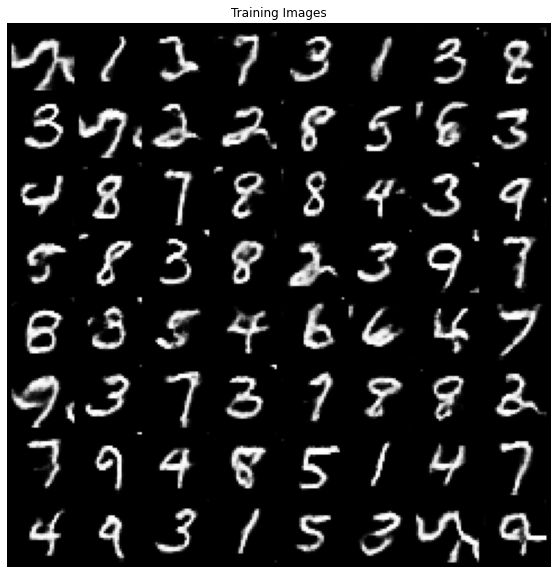

Epoch: [12][0/1093]	generator_loss: 0.6885 (0.6885)	discriminator_loss: 0.6869 (0.6869)	
Epoch: [12][200/1093]	generator_loss: 0.7845 (0.8238)	discriminator_loss: 0.6747 (0.6447)	
Epoch: [12][400/1093]	generator_loss: 0.9074 (0.8293)	discriminator_loss: 0.6472 (0.6474)	
Epoch: [12][600/1093]	generator_loss: 0.7174 (0.8313)	discriminator_loss: 0.6699 (0.6471)	
Epoch: [12][800/1093]	generator_loss: 0.8837 (0.8338)	discriminator_loss: 0.6292 (0.6479)	
Epoch: [12][1000/1093]	generator_loss: 1.0124 (0.8347)	discriminator_loss: 0.5470 (0.6469)	


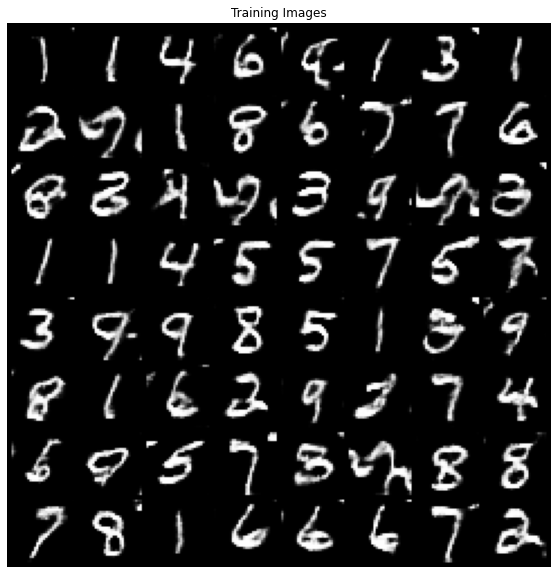

Epoch: [13][0/1093]	generator_loss: 0.8440 (0.8440)	discriminator_loss: 0.6760 (0.6760)	
Epoch: [13][200/1093]	generator_loss: 0.7716 (0.8264)	discriminator_loss: 0.6566 (0.6454)	
Epoch: [13][400/1093]	generator_loss: 0.8396 (0.8376)	discriminator_loss: 0.6902 (0.6451)	
Epoch: [13][600/1093]	generator_loss: 0.8181 (0.8328)	discriminator_loss: 0.6817 (0.6452)	
Epoch: [13][800/1093]	generator_loss: 0.8151 (0.8354)	discriminator_loss: 0.6405 (0.6443)	
Epoch: [13][1000/1093]	generator_loss: 0.8406 (0.8348)	discriminator_loss: 0.6346 (0.6449)	


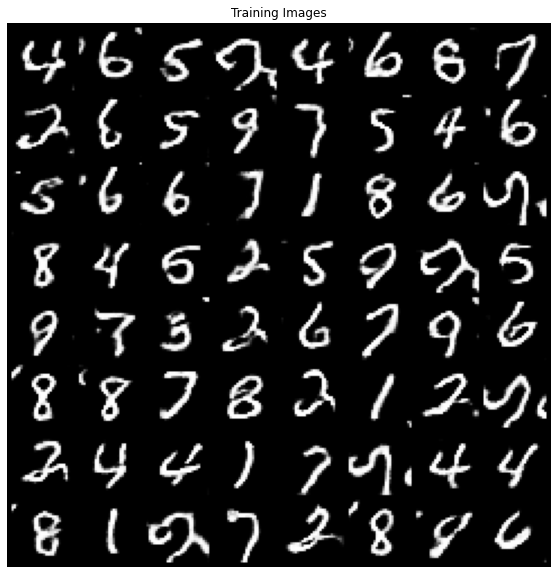

Epoch: [14][0/1093]	generator_loss: 0.8326 (0.8326)	discriminator_loss: 0.6119 (0.6119)	
Epoch: [14][200/1093]	generator_loss: 0.9085 (0.8516)	discriminator_loss: 0.5743 (0.6396)	
Epoch: [14][400/1093]	generator_loss: 0.8904 (0.8460)	discriminator_loss: 0.6480 (0.6437)	
Epoch: [14][600/1093]	generator_loss: 0.8807 (0.8431)	discriminator_loss: 0.6687 (0.6409)	
Epoch: [14][800/1093]	generator_loss: 0.8723 (0.8474)	discriminator_loss: 0.6505 (0.6416)	
Epoch: [14][1000/1093]	generator_loss: 0.8659 (0.8451)	discriminator_loss: 0.6095 (0.6417)	


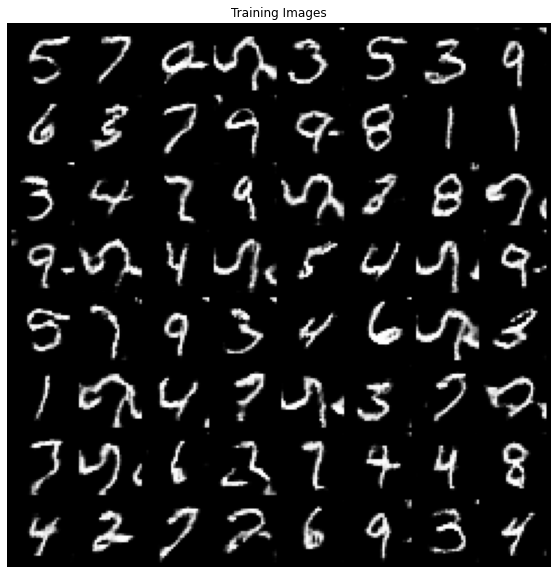

Epoch: [15][0/1093]	generator_loss: 0.7094 (0.7094)	discriminator_loss: 0.7565 (0.7565)	
Epoch: [15][200/1093]	generator_loss: 0.8361 (0.8363)	discriminator_loss: 0.6246 (0.6478)	
Epoch: [15][400/1093]	generator_loss: 0.9561 (0.8444)	discriminator_loss: 0.6454 (0.6436)	
Epoch: [15][600/1093]	generator_loss: 0.8585 (0.8452)	discriminator_loss: 0.6429 (0.6410)	
Epoch: [15][800/1093]	generator_loss: 1.0320 (0.8499)	discriminator_loss: 0.6160 (0.6383)	
Epoch: [15][1000/1093]	generator_loss: 0.7478 (0.8500)	discriminator_loss: 0.7230 (0.6386)	


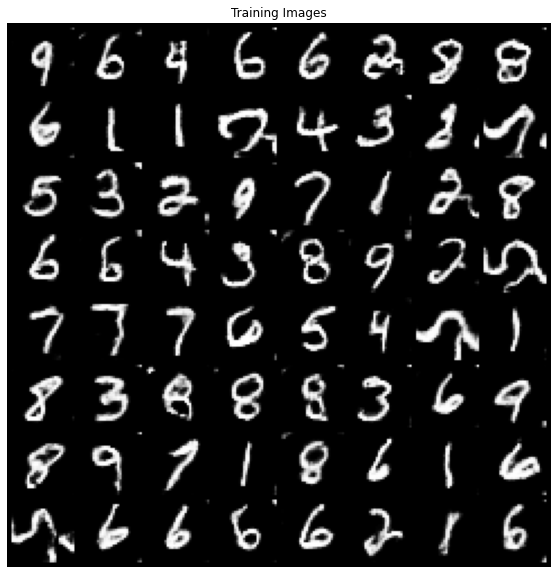

Epoch: [16][0/1093]	generator_loss: 0.8162 (0.8162)	discriminator_loss: 0.6664 (0.6664)	
Epoch: [16][200/1093]	generator_loss: 0.8127 (0.8412)	discriminator_loss: 0.6640 (0.6390)	
Epoch: [16][400/1093]	generator_loss: 0.8071 (0.8344)	discriminator_loss: 0.6311 (0.6361)	
Epoch: [16][600/1093]	generator_loss: 0.9052 (0.8468)	discriminator_loss: 0.6642 (0.6357)	
Epoch: [16][800/1093]	generator_loss: 0.8897 (0.8476)	discriminator_loss: 0.6029 (0.6350)	
Epoch: [16][1000/1093]	generator_loss: 0.9786 (0.8527)	discriminator_loss: 0.5465 (0.6336)	


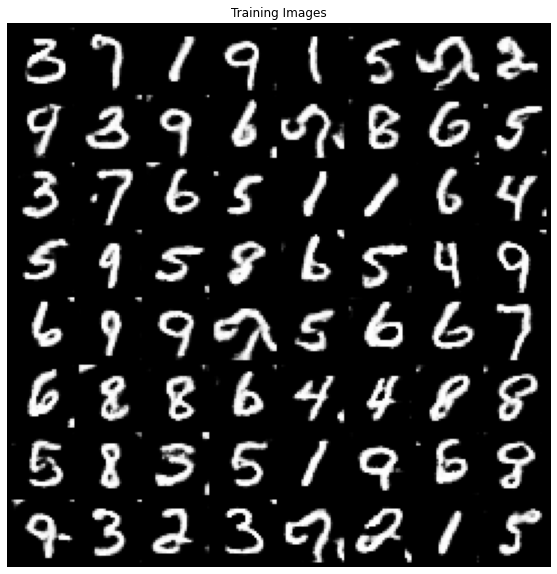

Epoch: [17][0/1093]	generator_loss: 0.7647 (0.7647)	discriminator_loss: 0.5865 (0.5865)	
Epoch: [17][200/1093]	generator_loss: 0.9156 (0.8559)	discriminator_loss: 0.5861 (0.6278)	
Epoch: [17][400/1093]	generator_loss: 0.8858 (0.8638)	discriminator_loss: 0.6707 (0.6266)	
Epoch: [17][600/1093]	generator_loss: 0.7785 (0.8666)	discriminator_loss: 0.7393 (0.6273)	
Epoch: [17][800/1093]	generator_loss: 0.9180 (0.8701)	discriminator_loss: 0.6452 (0.6274)	
Epoch: [17][1000/1093]	generator_loss: 0.8344 (0.8712)	discriminator_loss: 0.5952 (0.6275)	


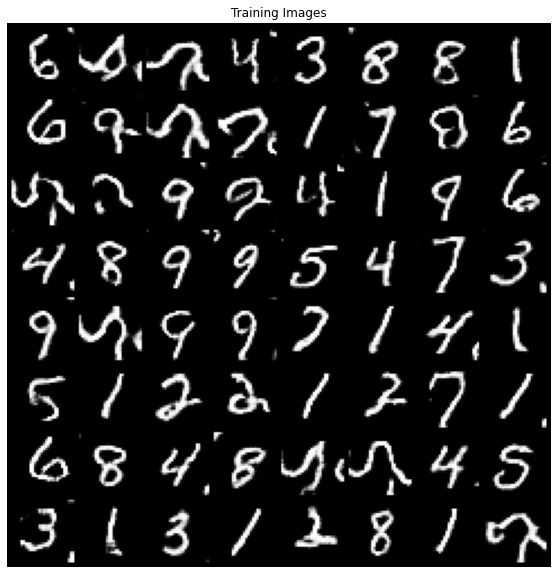

Epoch: [18][0/1093]	generator_loss: 0.9267 (0.9267)	discriminator_loss: 0.6162 (0.6162)	
Epoch: [18][200/1093]	generator_loss: 0.8790 (0.8700)	discriminator_loss: 0.6237 (0.6194)	
Epoch: [18][400/1093]	generator_loss: 0.8102 (0.8769)	discriminator_loss: 0.6217 (0.6207)	
Epoch: [18][600/1093]	generator_loss: 0.8153 (0.8731)	discriminator_loss: 0.6132 (0.6206)	
Epoch: [18][800/1093]	generator_loss: 1.1493 (0.8781)	discriminator_loss: 0.5139 (0.6186)	
Epoch: [18][1000/1093]	generator_loss: 0.9073 (0.8813)	discriminator_loss: 0.6230 (0.6188)	


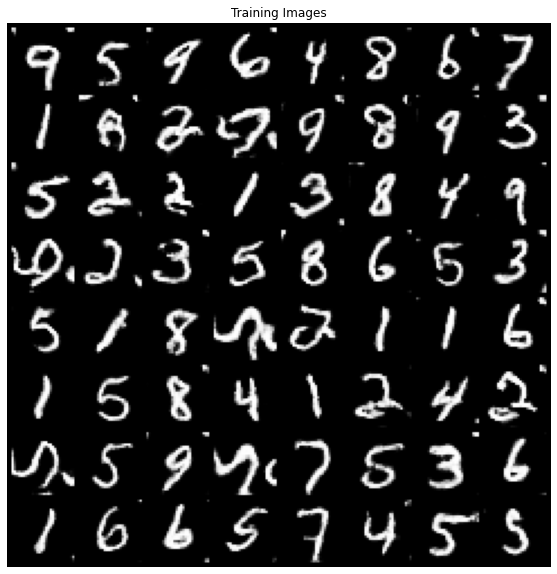

Epoch: [19][0/1093]	generator_loss: 1.0277 (1.0277)	discriminator_loss: 0.6516 (0.6516)	
Epoch: [19][200/1093]	generator_loss: 0.8205 (0.8728)	discriminator_loss: 0.6262 (0.6195)	
Epoch: [19][400/1093]	generator_loss: 0.8109 (0.8690)	discriminator_loss: 0.5602 (0.6173)	
Epoch: [19][600/1093]	generator_loss: 0.8090 (0.8696)	discriminator_loss: 0.6490 (0.6176)	
Epoch: [19][800/1093]	generator_loss: 0.9072 (0.8674)	discriminator_loss: 0.6134 (0.6179)	
Epoch: [19][1000/1093]	generator_loss: 0.8991 (0.8697)	discriminator_loss: 0.5836 (0.6172)	


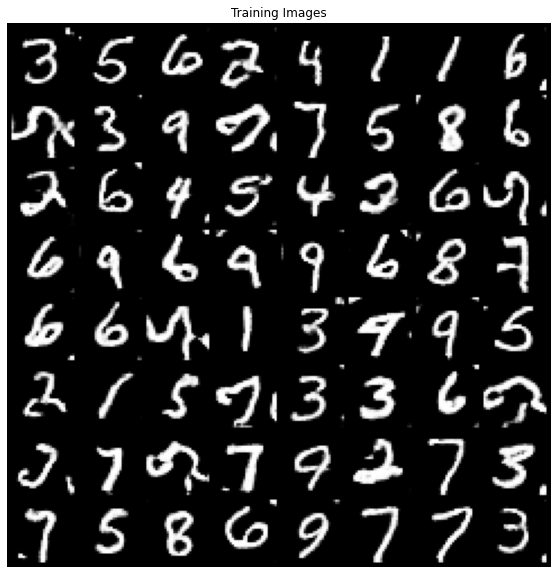

In [13]:
for epoch in range(epochs) :
    generator.train()
    discriminator.train()
    
    gen_loss_tracker = AverageMeter()
    disc_loss_tracker = AverageMeter()
    
    for i, (images, labels) in enumerate(train_loader):
        labels = F.one_hot(labels, num_classes=num_classes)
        images = images.to(device)
        labels = labels.to(device)
        
        random_latent_vectors = torch.randn(batch_size, latent_dim)
        random_latent_vectors = random_latent_vectors.to(device)
    
        generated_images = generator(random_latent_vectors, labels)
        predictions_fake, _ = discriminator(generated_images, labels)
        predictions_real, _ = discriminator(images, labels)
        combined_predictions = torch.cat(
            (predictions_fake, predictions_real), 0
        )
        
        gt_labels = torch.cat(
            (torch.ones(batch_size, 1), torch.zeros(batch_size, 1)), 0
        ).to(device)
        
        d_loss = criterion(combined_predictions, gt_labels)
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        random_latent_vectors = torch.randn(batch_size, latent_dim).to(device)
        
        generated_images = generator(random_latent_vectors, labels)
        predictions_fake_to_real, tmp = discriminator(generated_images, labels)
    
        misleading_labels = torch.zeros(batch_size, 1).to(device)
        
        g_loss = criterion(predictions_fake_to_real, misleading_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        disc_loss_tracker.update(np.mean(d_loss.item()))
        gen_loss_tracker.update(np.mean(g_loss.item()))
        if i % 200 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'generator_loss: {gen_loss_tracker.val:.4f} ({gen_loss_tracker.avg:.4f})\t'
                  'discriminator_loss: {disc_loss_tracker.val:.4f} ({disc_loss_tracker.avg:.4f})\t'
                  .format(epoch, i, len(train_loader),
                          gen_loss_tracker=gen_loss_tracker,
                          disc_loss_tracker=disc_loss_tracker))
            

    plt.figure(figsize=(10,10)) 
    plt.axis("off") 
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(generated_images.detach().to('cpu'), 
                                             padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

In [14]:
tmp[0, 1:, 0, 0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SelectBackward>)

In [27]:
tmp[0, 2, :, :]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [16]:
num_interpolation = 9
interpolation_noise = torch.randn(1, latent_dim)
interpolation_noise = torch.repeat_interleave(interpolation_noise, num_interpolation)
interpolation_noise = torch.reshape(interpolation_noise, (num_interpolation, latent_dim))
interpolation_noise = interpolation_noise.to(device)

def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = F.one_hot(torch.tensor([first_number]), num_classes)
    second_label = F.one_hot(torch.tensor([second_number]), num_classes)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = torch.linspace(0, 1, num_interpolation)[:, None]
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    ).to(device)

    fake = generator(interpolation_noise, interpolation_labels)
    return fake
start_class = 3  
end_class = 8  

fake_images = interpolate_class(start_class, end_class)

In [18]:
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 10]))

In [19]:
gen_label = F.one_hot(torch.randint(0,10,(batch_size,))).to(device)
gen_label.shape

torch.Size([64, 10])

In [31]:
(labels*gen_label).sum()

tensor(7, device='cuda:0')

In [20]:
nn.Sigmoid()(discriminator(images, labels)[0]).mean()

tensor(0.4820, device='cuda:0', grad_fn=<MeanBackward0>)

In [21]:
nn.Sigmoid()(discriminator(images, gen_label)[0]).mean()

tensor(0.4995, device='cuda:0', grad_fn=<MeanBackward0>)

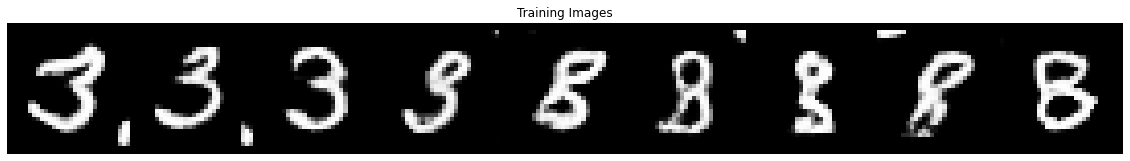

In [17]:
plt.figure(figsize=(20,20)) 
plt.axis("off") 
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images.detach().to('cpu'), nrow=10,
                                         padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()